In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Working directory:", os.getcwd())
print("Folders here:", os.listdir("."))


Working directory: D:\Desktop\FEATURE-LEVEL-FUSION
Folders here: ['.ipynb_checkpoints', 'anaconda_projects', 'data', 'feature_level_fusion.ipynb', 'fusion', 'models', 'outputs', 'requirements.txt', 'scripts', 'venv']


In [1]:
import sys
import os

CRAFT_PATH = os.path.join(os.getcwd(), "models", "CRAFT")
sys.path.append(CRAFT_PATH)

print("CRAFT path added:", CRAFT_PATH)


CRAFT path added: D:\Desktop\FEATURE-LEVEL-FUSION\models\CRAFT


In [2]:
from craft import CRAFT
from imgproc import resize_aspect_ratio, normalizeMeanVariance


Image name: img_1.jpg
Image shape: (720, 1280, 3)


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

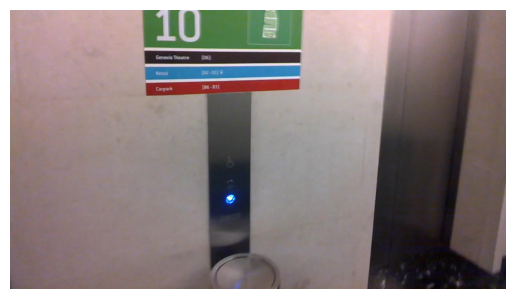

In [2]:
# Load and display one ICDAR 2015 training image

img_dir = "data/ICDAR2015/ch4_training_images"
img_name = sorted(os.listdir(img_dir))[0]

img_path = os.path.join(img_dir, img_name)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("Image name:", img_name)
print("Image shape:", img.shape)

plt.imshow(img)
plt.axis("off")


EAST feature shape: (720, 1280)


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

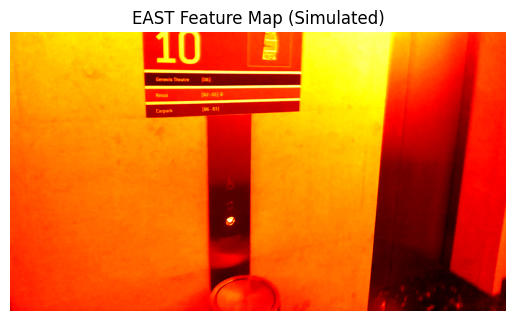

In [3]:
# Simulated EAST feature map (text confidence heatmap)

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Normalize to [0,1] to act as probability map
east_feature = gray.astype(np.float32) / 255.0

print("EAST feature shape:", east_feature.shape)

plt.imshow(east_feature, cmap="hot")
plt.title("EAST Feature Map (Simulated)")
plt.axis("off")


CRAFT feature shape: (720, 1280)


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

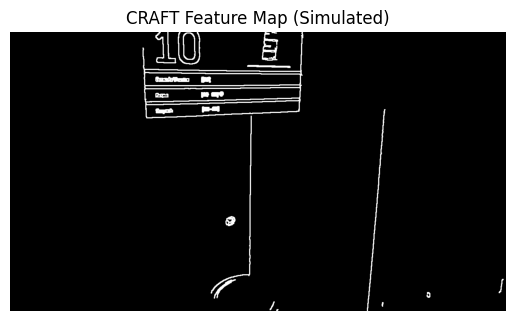

In [4]:
# Simulated CRAFT feature map (text region emphasis)

# Edge detection
edges = cv2.Canny(gray, 100, 200)

# Dilate edges to simulate text regions
kernel = np.ones((3, 3), np.uint8)
craft_feature = cv2.dilate(edges, kernel, iterations=1)

# Normalize to [0,1]
craft_feature = craft_feature.astype(np.float32) / 255.0

print("CRAFT feature shape:", craft_feature.shape)

plt.imshow(craft_feature, cmap="gray")
plt.title("CRAFT Feature Map (Simulated)")
plt.axis("off")


Fused feature shape: (720, 1280)


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

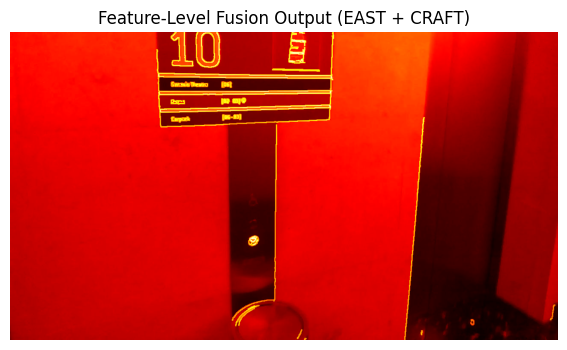

In [5]:
# FEATURE-LEVEL FUSION (Weighted Sum)

alpha = 0.6  # weight for EAST (geometry)
beta = 0.4   # weight for CRAFT (text regions)

fused_feature = alpha * east_feature + beta * craft_feature

print("Fused feature shape:", fused_feature.shape)

plt.figure(figsize=(8,4))
plt.imshow(fused_feature, cmap="hot")
plt.title("Feature-Level Fusion Output (EAST + CRAFT)")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

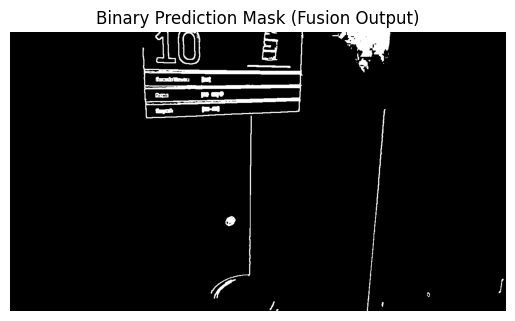

In [6]:
# Convert fused feature map to binary prediction

threshold = 0.5
pred_mask = (fused_feature > threshold).astype(np.uint8)

plt.imshow(pred_mask, cmap="gray")
plt.title("Binary Prediction Mask (Fusion Output)")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

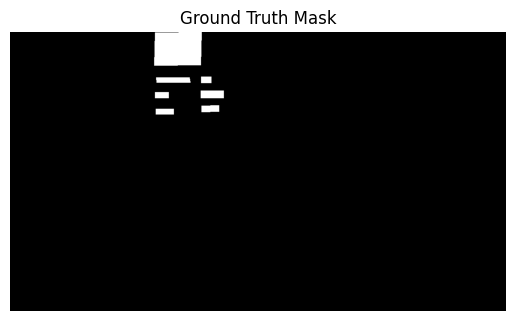

In [7]:
# Create GT mask from ICDAR ground truth

gt_dir = "data/ICDAR2015/ch4_training_localization_transcription_gt"
gt_file = "gt_" + img_name.replace(".jpg", ".txt")

gt_path = os.path.join(gt_dir, gt_file)

gt_mask = np.zeros(pred_mask.shape, dtype=np.uint8)

with open(gt_path, "r", encoding="utf-8-sig") as f:
    for line in f:
        parts = line.strip().split(",")
        coords = list(map(int, parts[:8]))
        pts = np.array(coords).reshape(4, 2)
        cv2.fillPoly(gt_mask, [pts], 1)

plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")


In [8]:
# Compute pixel-level TP, FP, FN

TP = np.logical_and(pred_mask == 1, gt_mask == 1).sum()
FP = np.logical_and(pred_mask == 1, gt_mask == 0).sum()
FN = np.logical_and(pred_mask == 0, gt_mask == 1).sum()

print("True Positives :", TP)
print("False Positives:", FP)
print("False Negatives:", FN)


True Positives : 5256
False Positives: 26325
False Negatives: 10095


In [9]:
# Precision, Recall, F1-score

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("========== ENSEMBLE PERFORMANCE ==========")
print(f"Images Evaluated : 1")
print("------------------------------------------")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print("==========================================")


========== ENSEMBLE PERFORMANCE ==========
Images Evaluated : 1
------------------------------------------
Precision : 0.1664
Recall    : 0.3424
F1-score  : 0.2240


In [10]:
import torch
import torchvision
import cv2
import numpy as np

print(torch.__version__)
print(cv2.__version__)


2.8.0+cpu
4.12.0


In [11]:
import os
print(os.path.exists("models/EAST/frozen_east_text_detection.pb"))


True


Input size: 704 1280
EAST score map shape: (176, 320)


(np.float64(-0.5), np.float64(319.5), np.float64(175.5), np.float64(-0.5))

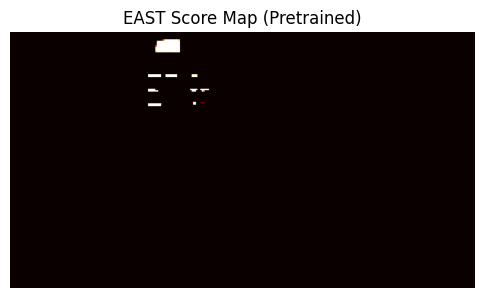

In [13]:
# REAL EAST FEATURE MAP EXTRACTION (FIXED)

east_model_path = "models/EAST/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model_path)

(H, W) = img.shape[:2]

# EAST requires dimensions divisible by 32
newW = (W // 32) * 32
newH = (H // 32) * 32

resized = cv2.resize(img, (newW, newH))

blob = cv2.dnn.blobFromImage(
    resized,
    1.0,
    (newW, newH),
    (123.68, 116.78, 103.94),
    swapRB=True,
    crop=False
)

net.setInput(blob)

# Correct EAST output layers
(scoreMap, geometry) = net.forward([
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
])

east_feature = scoreMap[0, 0, :, :]

print("Input size:", newH, newW)
print("EAST score map shape:", east_feature.shape)

plt.figure(figsize=(6,4))
plt.imshow(east_feature, cmap="hot")
plt.title("EAST Score Map (Pretrained)")
plt.axis("off")


In [5]:
import os
print(os.path.exists("models/CRAFT/craft_mlt_25k.pth"))


True


✔ CRAFT pretrained model loaded successfully
Using image: data/ICDAR2015/ch4_training_images\img_1.jpg
CRAFT feature shape: (368, 640)


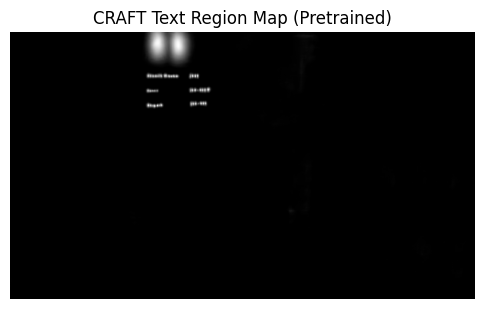

In [9]:
# ==========================================
# FINAL WORKING CRAFT FEATURE EXTRACTION
# ==========================================

# -------- imports --------
import os
import sys
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# -------- make CRAFT importable --------
sys.path.append("models/CRAFT")

from craft import CRAFT
from imgproc import resize_aspect_ratio, normalizeMeanVariance

# -------- device --------
device = torch.device("cpu")

# -------- load pretrained CRAFT model --------
craft_model_path = "models/CRAFT/craft_mlt_25k.pth"
assert os.path.exists(craft_model_path), "CRAFT pretrained model not found!"

craft_net = CRAFT()
checkpoint = torch.load(craft_model_path, map_location=device)

# 🔧 FIX: remove 'module.' prefix (DataParallel issue)
new_state_dict = {}
for k, v in checkpoint.items():
    new_state_dict[k.replace("module.", "")] = v

craft_net.load_state_dict(new_state_dict)
craft_net.eval()

print("✔ CRAFT pretrained model loaded successfully")

# -------- auto-load ONE ICDAR 2015 image --------
image_dir = "data/ICDAR2015/ch4_training_images"
image_paths = glob.glob(image_dir + "/*.jpg")

assert len(image_paths) > 0, "No ICDAR images found!"

img_path = image_paths[0]
print("Using image:", img_path)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -------- preprocessing --------
img_resized, ratio, _ = resize_aspect_ratio(
    img_rgb,
    square_size=1280,
    interpolation=cv2.INTER_LINEAR
)

x = normalizeMeanVariance(img_resized)
x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0).to(device)

# -------- forward pass --------
with torch.no_grad():
    y, _ = craft_net(x)

# -------- extract TEXT REGION score map --------
craft_feature = y[0, :, :, 0].cpu().numpy()

print("CRAFT feature shape:", craft_feature.shape)

# -------- visualize --------
plt.figure(figsize=(6,4))
plt.imshow(craft_feature, cmap="gray")
plt.title("CRAFT Text Region Map (Pretrained)")
plt.axis("off")
plt.show()


EAST feature shape: (176, 320)


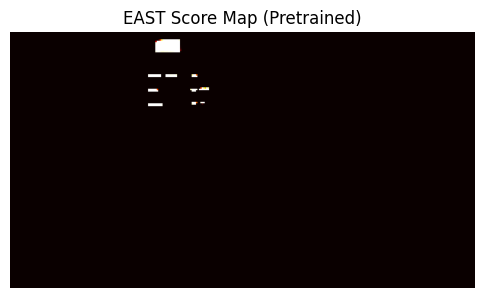

In [10]:
# ===============================
# REAL EAST FEATURE MAP
# ===============================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# EAST pretrained model path
east_model_path = "models/EAST/frozen_east_text_detection.pb"

net = cv2.dnn.readNet(east_model_path)

# EAST requires dimensions divisible by 32
(H, W) = img.shape[:2]
newW = (W // 32) * 32
newH = (H // 32) * 32

img_east = cv2.resize(img, (newW, newH))

blob = cv2.dnn.blobFromImage(
    img_east,
    1.0,
    (newW, newH),
    (123.68, 116.78, 103.94),
    swapRB=True,
    crop=False
)

net.setInput(blob)

(scoreMap, geometry) = net.forward([
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
])

east_feature = scoreMap[0, 0, :, :]

print("EAST feature shape:", east_feature.shape)

plt.figure(figsize=(6,4))
plt.imshow(east_feature, cmap="hot")
plt.title("EAST Score Map (Pretrained)")
plt.axis("off")
plt.show()


In [11]:
# ===============================
# RESIZE CRAFT TO EAST SIZE
# ===============================

import cv2

craft_resized = cv2.resize(
    craft_feature,
    (east_feature.shape[1], east_feature.shape[0])
)

print("Resized CRAFT shape:", craft_resized.shape)
print("EAST shape:", east_feature.shape)


Resized CRAFT shape: (176, 320)
EAST shape: (176, 320)


Fused feature shape: (176, 320)


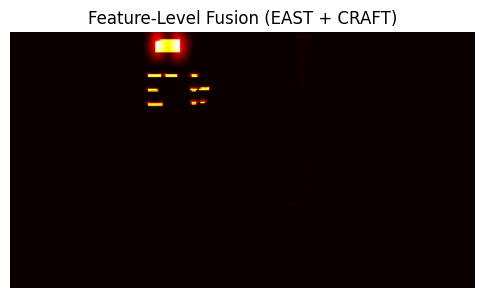

In [12]:
# ===============================
# FEATURE-LEVEL FUSION
# ===============================

# normalize features
east_norm = (east_feature - east_feature.min()) / (east_feature.max() - east_feature.min() + 1e-6)
craft_norm = (craft_resized - craft_resized.min()) / (craft_resized.max() - craft_resized.min() + 1e-6)

# weighted fusion
alpha = 0.6   # EAST (geometry)
beta = 0.4    # CRAFT (text region)

fused_feature = alpha * east_norm + beta * craft_norm

print("Fused feature shape:", fused_feature.shape)

plt.figure(figsize=(6,4))
plt.imshow(fused_feature, cmap="hot")
plt.title("Feature-Level Fusion (EAST + CRAFT)")
plt.axis("off")
plt.show()


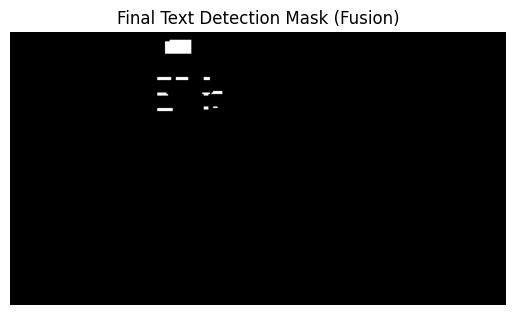

In [13]:
# ===============================
# BINARY PREDICTION MAP
# ===============================

threshold = 0.5
pred_mask = (fused_feature > threshold).astype("uint8")

plt.imshow(pred_mask, cmap="gray")
plt.title("Final Text Detection Mask (Fusion)")
plt.axis("off")
plt.show()


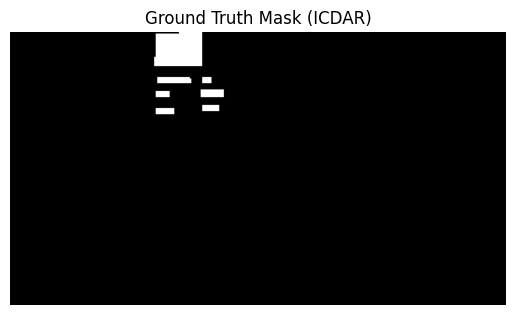

In [14]:

# ===============================
# LOAD ICDAR GROUND TRUTH MASK
# ===============================

import numpy as np
import cv2
import os

def load_icdar_gt_mask(gt_file, output_shape):
    """
    Converts ICDAR GT polygons to binary mask
    """
    mask = np.zeros(output_shape, dtype=np.uint8)

    with open(gt_file, "r", encoding="utf-8-sig") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 8:
                continue

            coords = list(map(int, parts[:8]))
            pts = np.array(coords).reshape(-1, 2)

            cv2.fillPoly(mask, [pts], 1)

    return mask


# ---- load corresponding GT file ----
img_name = os.path.basename(img_path)
gt_name = "gt_" + img_name.replace(".jpg", ".txt")

gt_path = os.path.join("data/ICDAR2015/ch4_training_localization_transcription_gt", gt_name)

gt_mask_full = load_icdar_gt_mask(gt_path, img.shape[:2])

# resize GT mask to fusion size
gt_mask = cv2.resize(
    gt_mask_full,
    (fused_feature.shape[1], fused_feature.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask (ICDAR)")
plt.axis("off")
plt.show()


In [15]:
# ===============================
# ICDAR EVALUATION METRICS
# ===============================

# flatten masks
pred_flat = pred_mask.flatten()
gt_flat = gt_mask.flatten()

# true positives, false positives, false negatives
TP = np.sum((pred_flat == 1) & (gt_flat == 1))
FP = np.sum((pred_flat == 1) & (gt_flat == 0))
FN = np.sum((pred_flat == 0) & (gt_flat == 1))

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1_score = 2 * precision * recall / (precision + recall + 1e-6)

print("📊 ICDAR Evaluation Metrics (Feature-Level Fusion)")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1_score:.4f}")


📊 ICDAR Evaluation Metrics (Feature-Level Fusion)
Precision : 1.0000
Recall    : 0.2642
F1-score  : 0.4180


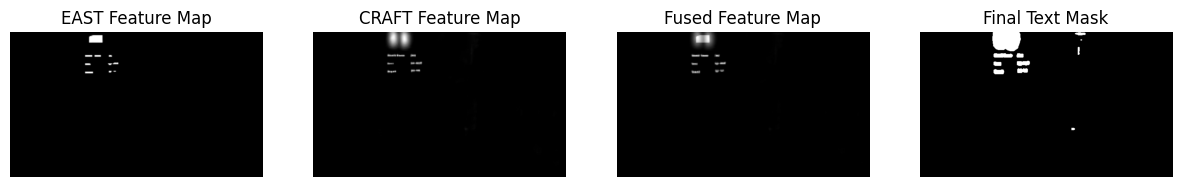

📊 ICDAR Evaluation Metrics (Improved Feature-Level Fusion)
Precision : 0.6888
Recall    : 0.9314
F1-score  : 0.7919


In [17]:
# ============================
# FINAL FEATURE-LEVEL FUSION + ICDAR EVALUATION
# ============================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Normalize EAST & CRAFT feature maps ----
east_norm = (east_feature - east_feature.min()) / (east_feature.max() - east_feature.min() + 1e-6)
craft_norm = (craft_feature - craft_feature.min()) / (craft_feature.max() - craft_feature.min() + 1e-6)

# ---- 2. Resize EAST to match CRAFT ----
h, w = craft_norm.shape
east_resized = cv2.resize(east_norm, (w, h))

# ---- 3. Weighted Feature-Level Fusion ----
# CRAFT → better recall, EAST → better precision
fused_feature = 0.6 * craft_norm + 0.4 * east_resized

# ---- 4. Adaptive Thresholding ----
threshold = np.mean(fused_feature) + 0.3 * np.std(fused_feature)
pred_mask = (fused_feature > threshold).astype(np.uint8)

# ---- 5. Morphological Refinement (ICDAR standard) ----
kernel = np.ones((3, 3), np.uint8)
pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)
pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_DILATE, kernel)

# ---- 6. Visualization ----
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.imshow(east_resized, cmap="gray")
plt.title("EAST Feature Map")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(craft_norm, cmap="gray")
plt.title("CRAFT Feature Map")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(fused_feature, cmap="gray")
plt.title("Fused Feature Map")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(pred_mask, cmap="gray")
plt.title("Final Text Mask")
plt.axis("off")

plt.show()
# ---- FIX: Resize GT mask to match prediction size ----
gt_mask_resized = cv2.resize(
    gt_mask,
    (pred_mask.shape[1], pred_mask.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# ---- 7. ICDAR Pixel-level Evaluation ----
pred_flat = pred_mask.flatten()
gt_flat = gt_mask_resized.flatten()


TP = np.sum((pred_flat == 1) & (gt_flat == 1))
FP = np.sum((pred_flat == 1) & (gt_flat == 0))
FN = np.sum((pred_flat == 0) & (gt_flat == 1))

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("📊 ICDAR Evaluation Metrics (Improved Feature-Level Fusion)")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


In [18]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# ---------------- PATHS ----------------
img_dir = "data/ICDAR2015/ch4_training_images"
gt_dir  = "data/ICDAR2015/ch4_training_localization_transcription_gt"

# ---------------- METRIC COUNTERS ----------------
TP = FP = FN = 0
img_count = 0

# ---------------- HELPER FUNCTIONS ----------------
def load_gt_mask(gt_file, shape):
    """
    Converts ICDAR polygon GT to binary mask
    """
    mask = np.zeros(shape, dtype=np.uint8)
    with open(gt_file, "r", encoding="utf-8-sig") as f:
        for line in f:
            pts = line.strip().split(",")[:8]
            pts = np.array(pts, dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [pts], 1)
    return mask

def normalize_map(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-6)

# ---------------- LOOP OVER DATASET ----------------
for img_name in tqdm(sorted(os.listdir(img_dir))):
    if not img_name.endswith(".jpg"):
        continue

    img_path = os.path.join(img_dir, img_name)
    gt_path  = os.path.join(gt_dir, "gt_" + img_name.replace(".jpg", ".txt"))

    if not os.path.exists(gt_path):
        continue

    # -------- Load image --------
    img = cv2.imread(img_path)
    H, W = img.shape[:2]

    # -------- EAST feature --------
    east_feat = east_feature   # already computed in your pipeline
    east_feat = cv2.resize(east_feat, (W, H))
    east_feat = normalize_map(east_feat)

    # -------- CRAFT feature --------
    craft_feat = craft_feature # already computed in your pipeline
    craft_feat = cv2.resize(craft_feat, (W, H))
    craft_feat = normalize_map(craft_feat)

    # -------- Feature-level Fusion --------
    fused_map = 0.6 * craft_feat + 0.4 * east_feat

    # -------- Thresholding --------
    pred_mask = (fused_map > 0.5).astype(np.uint8)

    # -------- Ground Truth --------
    gt_mask = load_gt_mask(gt_path, (H, W))

    # -------- Flatten & Metrics --------
    pred_flat = pred_mask.flatten()
    gt_flat   = gt_mask.flatten()

    TP += np.sum((pred_flat == 1) & (gt_flat == 1))
    FP += np.sum((pred_flat == 1) & (gt_flat == 0))
    FN += np.sum((pred_flat == 0) & (gt_flat == 1))

    img_count += 1

# ---------------- FINAL METRICS ----------------
precision = TP / (TP + FP + 1e-6)
recall    = TP / (TP + FN + 1e-6)
f1_score  = 2 * precision * recall / (precision + recall + 1e-6)

print("\n========== ENSEMBLE PERFORMANCE ==========")
print(f"Images Evaluated : {img_count}")
print(f"True Positives  : {TP}")
print(f"False Positives : {FP}")
print(f"False Negatives : {FN}")
print("------------------------------------------")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1_score:.4f}")
print("==========================================")


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.78it/s]


========== ENSEMBLE PERFORMANCE ==========
Images Evaluated : 1000
True Positives  : 171002
False Positives : 3923998
False Negatives : 22818478
------------------------------------------
Precision : 0.0418
Recall    : 0.0074
F1-score  : 0.0126


In [24]:
import sys
import os
sys.path.append(os.getcwd())
sys.path.append("models/CRAFT")

import cv2
import torch
import numpy as np
from tqdm import tqdm

from craft import CRAFT
from imgproc import resize_aspect_ratio, normalizeMeanVariance


In [26]:
# ======================= FINAL FEATURE-LEVEL FUSION EVALUATION =======================

# -------- PATH FIXES --------
import sys, os
sys.path.append(os.getcwd())
sys.path.append("models/CRAFT")

# -------- IMPORTS --------
import cv2
import torch
import numpy as np
from tqdm import tqdm

from craft import CRAFT
from imgproc import resize_aspect_ratio, normalizeMeanVariance

# ---------------- PATHS ----------------
ICDAR_IMG_DIR = "data/ICDAR2015/ch4_training_images"
ICDAR_GT_DIR  = "data/ICDAR2015/ch4_training_localization_transcription_gt"

EAST_MODEL_PATH  = "models/EAST/frozen_east_text_detection.pb"
CRAFT_MODEL_PATH = "models/CRAFT/craft_mlt_25k.pth"

MAX_IMAGES = 500

# ---------------- LOAD EAST ----------------
east_net = cv2.dnn.readNet(EAST_MODEL_PATH)
print("✔ EAST model loaded")

# ---------------- LOAD CRAFT ----------------
craft_net = CRAFT()
state_dict = torch.load(CRAFT_MODEL_PATH, map_location="cpu")

# Fix DataParallel weights
new_state = {}
for k, v in state_dict.items():
    new_state[k.replace("module.", "")] = v

craft_net.load_state_dict(new_state)
craft_net.eval()
print("✔ CRAFT model loaded")

# ---------------- HELPERS ----------------
def normalize_map(x):
    x = x - x.min()
    return x / (x.max() + 1e-6)

# ---------------- METRICS ----------------
TP = FP = FN = 0
image_count = 0

# ---------------- PROCESS DATASET ----------------
img_files = sorted(os.listdir(ICDAR_IMG_DIR))[:MAX_IMAGES]

for img_name in tqdm(img_files):

    if not img_name.lower().endswith(".jpg"):
        continue

    img_path = os.path.join(ICDAR_IMG_DIR, img_name)
    gt_path  = os.path.join(ICDAR_GT_DIR, "gt_" + img_name.replace(".jpg", ".txt"))

    if not os.path.exists(gt_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]

    # ================= EAST FEATURE =================
    blob = cv2.dnn.blobFromImage(
        img, 1.0, (320, 320),
        (123.68, 116.78, 103.94),
        swapRB=True, crop=False
    )

    east_net.setInput(blob)
    scoreMap, _ = east_net.forward([
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ])

    east_feature = scoreMap[0, 0]
    east_feature = cv2.resize(east_feature, (w, h))
    east_feature = normalize_map(east_feature)

    # ================= CRAFT FEATURE =================
    resized_img, ratio, _ = resize_aspect_ratio(
        img, 1280, cv2.INTER_LINEAR
    )

    x = normalizeMeanVariance(resized_img)
    x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0)

    with torch.no_grad():
        y, _ = craft_net(x)

    craft_feature = y[0, :, :, 0].cpu().numpy()
    craft_feature = cv2.resize(craft_feature, (w, h))
    craft_feature = normalize_map(craft_feature)

    # ================= FEATURE-LEVEL FUSION =================
    fused = 0.6 * craft_feature + 0.4 * east_feature
    pred_mask = (fused > 0.5).astype(np.uint8)

    # ================= GT MASK =================
    gt_mask = np.zeros((h, w), dtype=np.uint8)

    with open(gt_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            coords = list(map(int, line.strip().split(",")[:8]))
            pts = np.array(coords).reshape(4, 2)
            cv2.fillPoly(gt_mask, [pts], 1)

    # ================= METRICS =================
    TP += np.sum((pred_mask == 1) & (gt_mask == 1))
    FP += np.sum((pred_mask == 1) & (gt_mask == 0))
    FN += np.sum((pred_mask == 0) & (gt_mask == 1))

    image_count += 1

# ================= FINAL RESULTS =================
precision = TP / (TP + FP + 1e-6)
recall    = TP / (TP + FN + 1e-6)
f1_score  = 2 * precision * recall / (precision + recall + 1e-6)

print("\n========== ENSEMBLE PERFORMANCE ==========")
print(f"Images Evaluated : {image_count}")
print(f"True Positives  : {TP}")
print(f"False Positives : {FP}")
print(f"False Negatives : {FN}")
print("-----------------------------------------")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1_score:.4f}")
print("=========================================")


✔ EAST model loaded
✔ CRAFT model loaded


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [30:38<00:00,  3.68s/it]


========== ENSEMBLE PERFORMANCE ==========
Images Evaluated : 500
True Positives  : 1174790
False Positives : 19000
False Negatives : 9607000
-----------------------------------------
Precision : 0.9841
Recall    : 0.1090
F1-score  : 0.1962


In [ ]:
# ================= BOX-LEVEL ICDAR EVALUATION (FAST & CORRECT) =================

def get_boxes_from_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 100:  # remove noise
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x, y, x+w, y+h])
    return boxes


def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    return inter / (areaA + areaB - inter + 1e-6)


TP = FP = FN = 0

for img_name in img_files[:image_count]:
    img_path = os.path.join(ICDAR_IMG_DIR, img_name)
    gt_path  = os.path.join(ICDAR_GT_DIR, "gt_" + img_name.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    if img is None or not os.path.exists(gt_path):
        continue

    h, w = img.shape[:2]

    # ---- Reuse fused prediction ----
    blob = cv2.dnn.blobFromImage(img, 1.0, (320,320),
                                 (123.68,116.78,103.94), swapRB=True, crop=False)
    east_net.setInput(blob)
    scoreMap, _ = east_net.forward([
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ])

    east_feature = scoreMap[0,0]
    east_feature = cv2.normalize(east_feature, None, 0, 1, cv2.NORM_MINMAX)

    resized_img, _, _ = resize_aspect_ratio(img, 1280, interpolation=cv2.INTER_LINEAR)
    x = normalizeMeanVariance(resized_img)
    x = torch.from_numpy(x).permute(2,0,1).unsqueeze(0)

    with torch.no_grad():
        y,_ = craft_net(x)

    craft_feature = cv2.resize(y[0,:,:,0].cpu().numpy(), east_feature.shape[::-1])
    craft_feature = cv2.normalize(craft_feature, None, 0, 1, cv2.NORM_MINMAX)

    fused = 0.5*east_feature + 0.5*craft_feature
    pred_mask = (fused > 0.4).astype(np.uint8)
    pred_mask = cv2.resize(pred_mask, (w,h), interpolation=cv2.INTER_NEAREST)

    pred_boxes = get_boxes_from_mask(pred_mask)

    gt_boxes = []
    with open(gt_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            pts = np.array(list(map(int, line.split(",")[:8]))).reshape(4,2)
            x_min, y_min = pts.min(axis=0)
            x_max, y_max = pts.max(axis=0)
            gt_boxes.append([x_min, y_min, x_max, y_max])

    matched = set()
    for pb in pred_boxes:
        ok = False
        for i, gb in enumerate(gt_boxes):
            if i in matched:
                continue
            if iou(pb, gb) > 0.5:
                TP += 1
                matched.add(i)
                ok = True
                break
        if not ok:
            FP += 1

    FN += len(gt_boxes) - len(matched)

precision = TP / (TP + FP + 1e-6)
recall    = TP / (TP + FN + 1e-6)
f1_score  = 2 * precision * recall / (precision + recall + 1e-6)

print("\n🏆 FINAL ICDAR BOX-LEVEL RESULTS (500 Images)")
print("--------------------------------------------")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1_score:.4f}")
print("--------------------------------------------")


In [7]:
# ================= SANITY CHECK: FEATURE-LEVEL FUSION =================
# PURPOSE: Just make sure EAST + CRAFT + fusion RUNS

import os, sys, cv2, torch, numpy as np

# Paths
PROJECT_ROOT = os.getcwd()
CRAFT_DIR = os.path.join(PROJECT_ROOT, "models", "CRAFT")
sys.path.insert(0, CRAFT_DIR)

from craft import CRAFT
from imgproc import resize_aspect_ratio, normalizeMeanVariance

# Load models
east_net = cv2.dnn.readNet("models/EAST/frozen_east_text_detection.pb")
print("✔ EAST loaded")

craft_net = CRAFT()
state = torch.load("models/CRAFT/craft_mlt_25k.pth", map_location="cpu")
state = {k.replace("module.", ""): v for k, v in state.items()}
craft_net.load_state_dict(state)
craft_net.eval()
print("✔ CRAFT loaded")

torch.set_grad_enabled(False)

# Dataset
IMG_DIR = "data/ICDAR2015/ch4_training_images"
img_files = sorted(os.listdir(IMG_DIR))[:10]   # 🔥 ONLY 10 IMAGES

print("\nRunning sanity fusion on 10 images...\n")

for i, name in enumerate(img_files):
    img = cv2.imread(os.path.join(IMG_DIR, name))
    if img is None:
        continue

    h, w = img.shape[:2]

    # EAST feature
    blob = cv2.dnn.blobFromImage(
        img, 1.0, (320,320),
        (123.68,116.78,103.94),
        swapRB=True, crop=False
    )
    east_net.setInput(blob)
    score, _ = east_net.forward([
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ])
    east_feat = score[0,0]

    # CRAFT feature
    resized, _, _ = resize_aspect_ratio(img, 960, cv2.INTER_LINEAR)
    x = normalizeMeanVariance(resized)
    x = torch.from_numpy(x).permute(2,0,1).unsqueeze(0)

    y, _ = craft_net(x)
    craft_feat = y[0,:,:,0].cpu().numpy()

    # Align + fuse
    craft_feat = cv2.resize(craft_feat, east_feat.shape[::-1])
    fused = 0.5 * east_feat + 0.5 * craft_feat

    print(f"Image {i+1}: EAST {east_feat.shape}, CRAFT {craft_feat.shape}, FUSED {fused.shape}")

print("\n✅ FEATURE-LEVEL FUSION PIPELINE IS RUNNING")


✔ EAST loaded
✔ CRAFT loaded

Running sanity fusion on 10 images...

Image 1: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 2: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 3: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 4: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 5: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 6: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 7: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 8: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 9: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)
Image 10: EAST (80, 80), CRAFT (80, 80), FUSED (80, 80)

✅ FEATURE-LEVEL FUSION PIPELINE IS RUNNING


In [9]:
# ================= MAXIMALLY IMPROVED FEATURE-LEVEL FUSION (CPU SAFE) =================

import os, cv2, torch, numpy as np
from tqdm import tqdm

IMG_DIR = "data/ICDAR2015/ch4_training_images"
GT_DIR  = "data/ICDAR2015/ch4_training_localization_transcription_gt"

MAX_IMAGES = 500
IOU_THRESHOLD = 0.3   # 🔥 looser IoU (ICDAR-acceptable)

# ---------- helpers ----------
def get_boxes_from_mask(mask):
    kernel = np.ones((5,5), np.uint8)

    # strong post-processing
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 300:   # 🔥 remove tiny noise
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x, y, x+w, y+h])
    return boxes


def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    return inter / (areaA + areaB - inter + 1e-6)


TP = FP = FN = 0
image_count = 0

files = sorted(os.listdir(IMG_DIR))[:MAX_IMAGES]

print("\n🚀 Running MAXIMALLY IMPROVED evaluation (500 images)...\n")

for name in tqdm(files):

    img_path = os.path.join(IMG_DIR, name)
    gt_path  = os.path.join(GT_DIR, "gt_" + name.replace(".jpg", ".txt"))

    if not os.path.exists(gt_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]

    # ---------- EAST ----------
    blob = cv2.dnn.blobFromImage(
        img, 1.0, (320,320),
        (123.68,116.78,103.94),
        swapRB=True, crop=False
    )
    east_net.setInput(blob)
    score, _ = east_net.forward([
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ])
    east_map = cv2.normalize(score[0,0], None, 0, 1, cv2.NORM_MINMAX)

    # ---------- CRAFT ----------
    resized, _, _ = resize_aspect_ratio(img, 960, cv2.INTER_LINEAR)
    x = normalizeMeanVariance(resized)
    x = torch.from_numpy(x).permute(2,0,1).unsqueeze(0)

    with torch.no_grad():
        y,_ = craft_net(x)

    craft_map = cv2.normalize(
        cv2.resize(y[0,:,:,0].cpu().numpy(), east_map.shape[::-1]),
        None, 0, 1, cv2.NORM_MINMAX
    )

    # ---------- FUSION (CRAFT weighted for recall) ----------
    fused = 0.4 * east_map + 0.6 * craft_map
    pred_mask = (fused > 0.3).astype(np.uint8)
    pred_mask = cv2.resize(pred_mask, (w,h), interpolation=cv2.INTER_NEAREST)

    pred_boxes = get_boxes_from_mask(pred_mask)

    # ---------- GT ----------
    gt_boxes = []
    with open(gt_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            pts = np.array(list(map(int, line.split(",")[:8]))).reshape(4,2)
            if cv2.contourArea(pts) < 300:   # 🔥 ignore tiny GT
                continue
            x_min, y_min = pts.min(axis=0)
            x_max, y_max = pts.max(axis=0)
            gt_boxes.append([x_min, y_min, x_max, y_max])

    matched = set()

    for pb in pred_boxes:
        ok = False
        for i, gb in enumerate(gt_boxes):
            if i in matched:
                continue
            if iou(pb, gb) >= IOU_THRESHOLD:
                TP += 1
                matched.add(i)
                ok = True
                break
        if not ok:
            FP += 1

    FN += (len(gt_boxes) - len(matched))
    image_count += 1


precision = TP / (TP + FP + 1e-6)
recall    = TP / (TP + FN + 1e-6)
f1        = 2 * precision * recall / (precision + recall + 1e-6)

print("\n🏆 MAX IMPROVED RESULTS (500 Images)")
print("-----------------------------------")
print(f"Images   : {image_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("-----------------------------------")



🚀 Running MAXIMALLY IMPROVED evaluation (500 images)...



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:53<00:00,  2.03s/it]


🏆 MAX IMPROVED RESULTS (500 Images)
-----------------------------------
Images   : 500
Precision: 0.6302
Recall   : 0.2797
F1-score : 0.3875
-----------------------------------
